In [1]:
from cmeutils.structure import gsd_rdf
import gsd.hoomd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
import signac
from utils import check_job_for_log_equilibrium
from unyt import Unit

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
symbol_dict = {1.0: "o", 0.8: "s", 0.7: "^", 0.6: "d"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 3
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["legend.markerscale"] = 1

In [3]:
project = signac.get_project("../../testing-model/npt-runs/")

# Check for equilibrium

In [4]:
for job in project.find_jobs({"doc.equilibrated": False}):
    if job.doc.runs != 0:
        check_job_for_log_equilibrium(job, trim_cut=4000, value="mdcomputeThermodynamicQuantitiesvolume")


# Sample Density

In [22]:
project.detect_schema()

ProjectSchema(<len=20>)

/home/chrisjones4/miniconda3/envs/pps-msibi/lib/python3.11/site-packages/synced_collections/numpy_utils.py:43: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


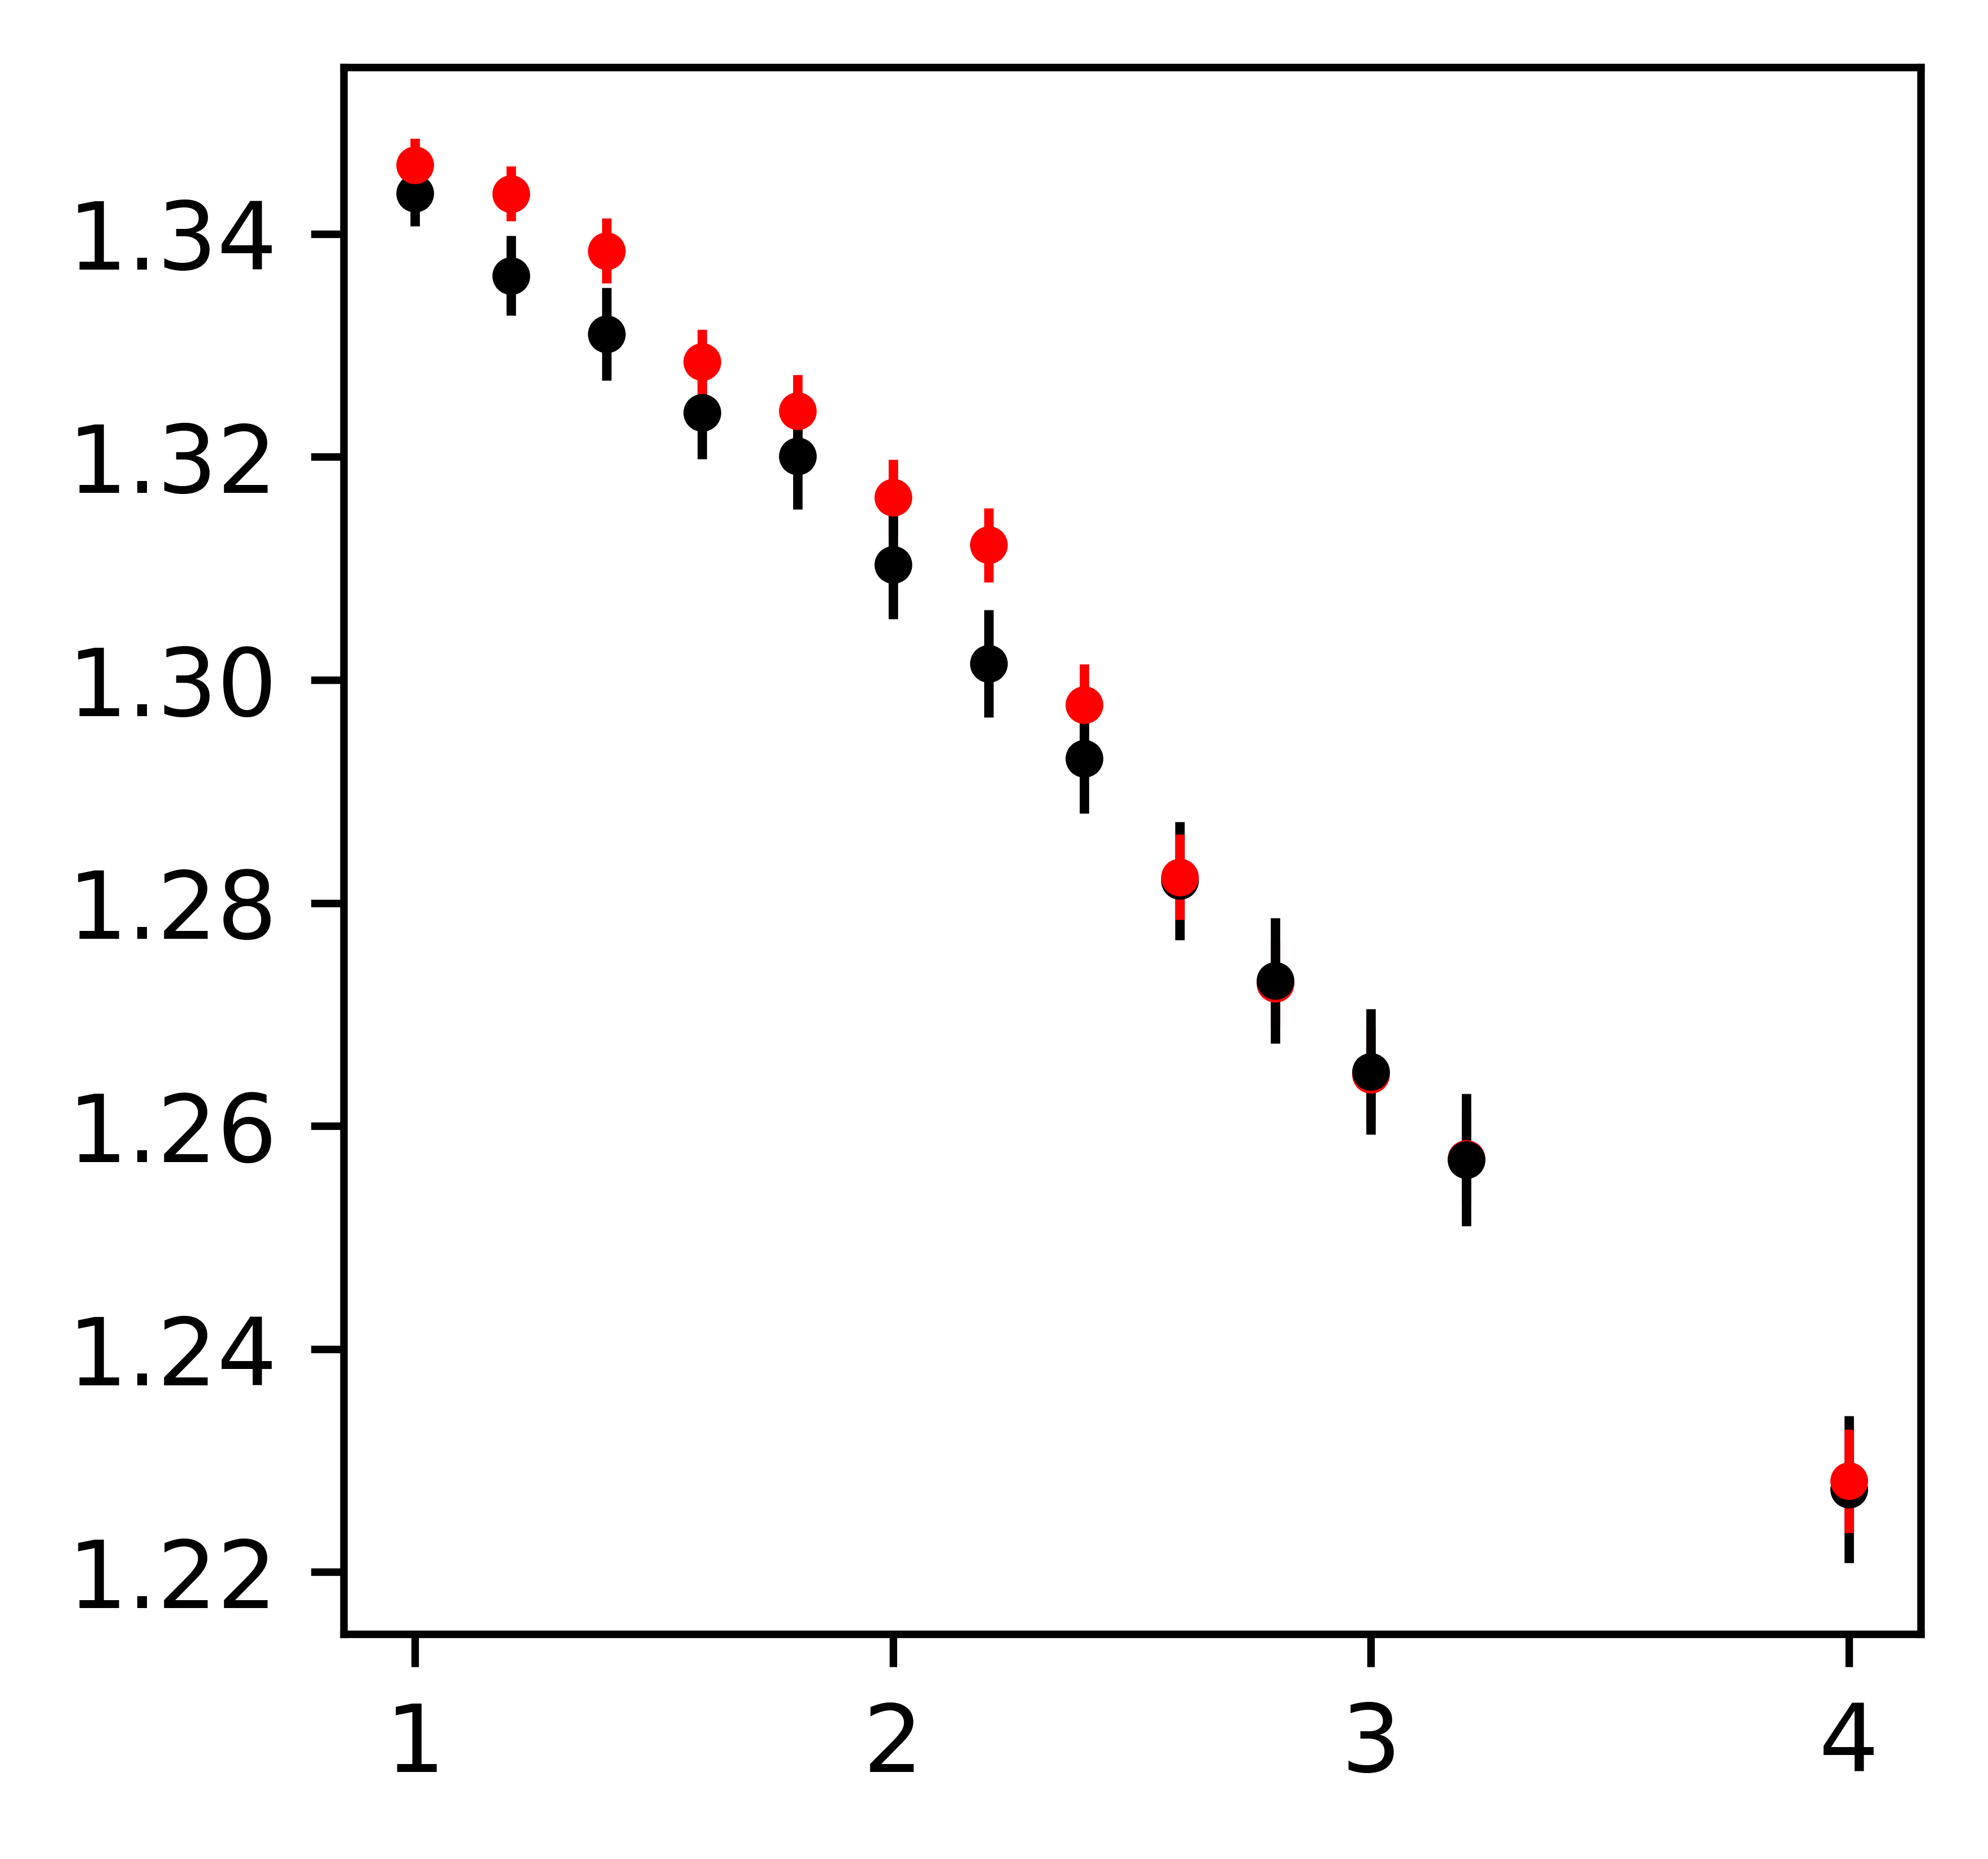

In [5]:
for job in project.find_jobs({"doc.equilibrated": True, "pressure": 3.5}):
    data = np.genfromtxt(job.fn(f"log{job.doc.runs - 1}.txt"), names=True)
    vol = data["mdcomputeThermodynamicQuantitiesvolume"]
    vol_sample_raw = vol[job.doc.log_equil_start:-1:job.doc.equil_log_stride]
    vol_sample = (vol_sample_raw * (job.doc.ref_length**3) * Unit(f"{job.doc.ref_length_units}**3")).to("cm**3")
    vol_avg = np.mean(vol_sample)
    vol_std = np.std(vol_sample)

    if job.sp.lengths == 100:
        c = "red"
    else:
        c = "black"

    with gsd.hoomd.open(job.fn("trajectory0.gsd")) as traj:
        snap = traj[0]
        total_mass = sum((snap.particles.mass * job.doc.ref_mass * Unit(job.doc.ref_mass_units)).to("g"))
        job.doc.total_mass_g = total_mass.value
        density = total_mass / vol_sample
        density_avg = np.mean(density)
        density_std = np.std(density)
        job.doc.density_avg = density_avg
        job.doc.density_std = density_std

    plt.errorbar(
        x=job.sp.kT,
        y=job.doc.density_avg,
        yerr=job.doc.density_std,
        color=c,
        marker="o"
    )


In [15]:
np.save(arr=temps, file="temperature.npy")
np.save(arr=density, file="density.npy")

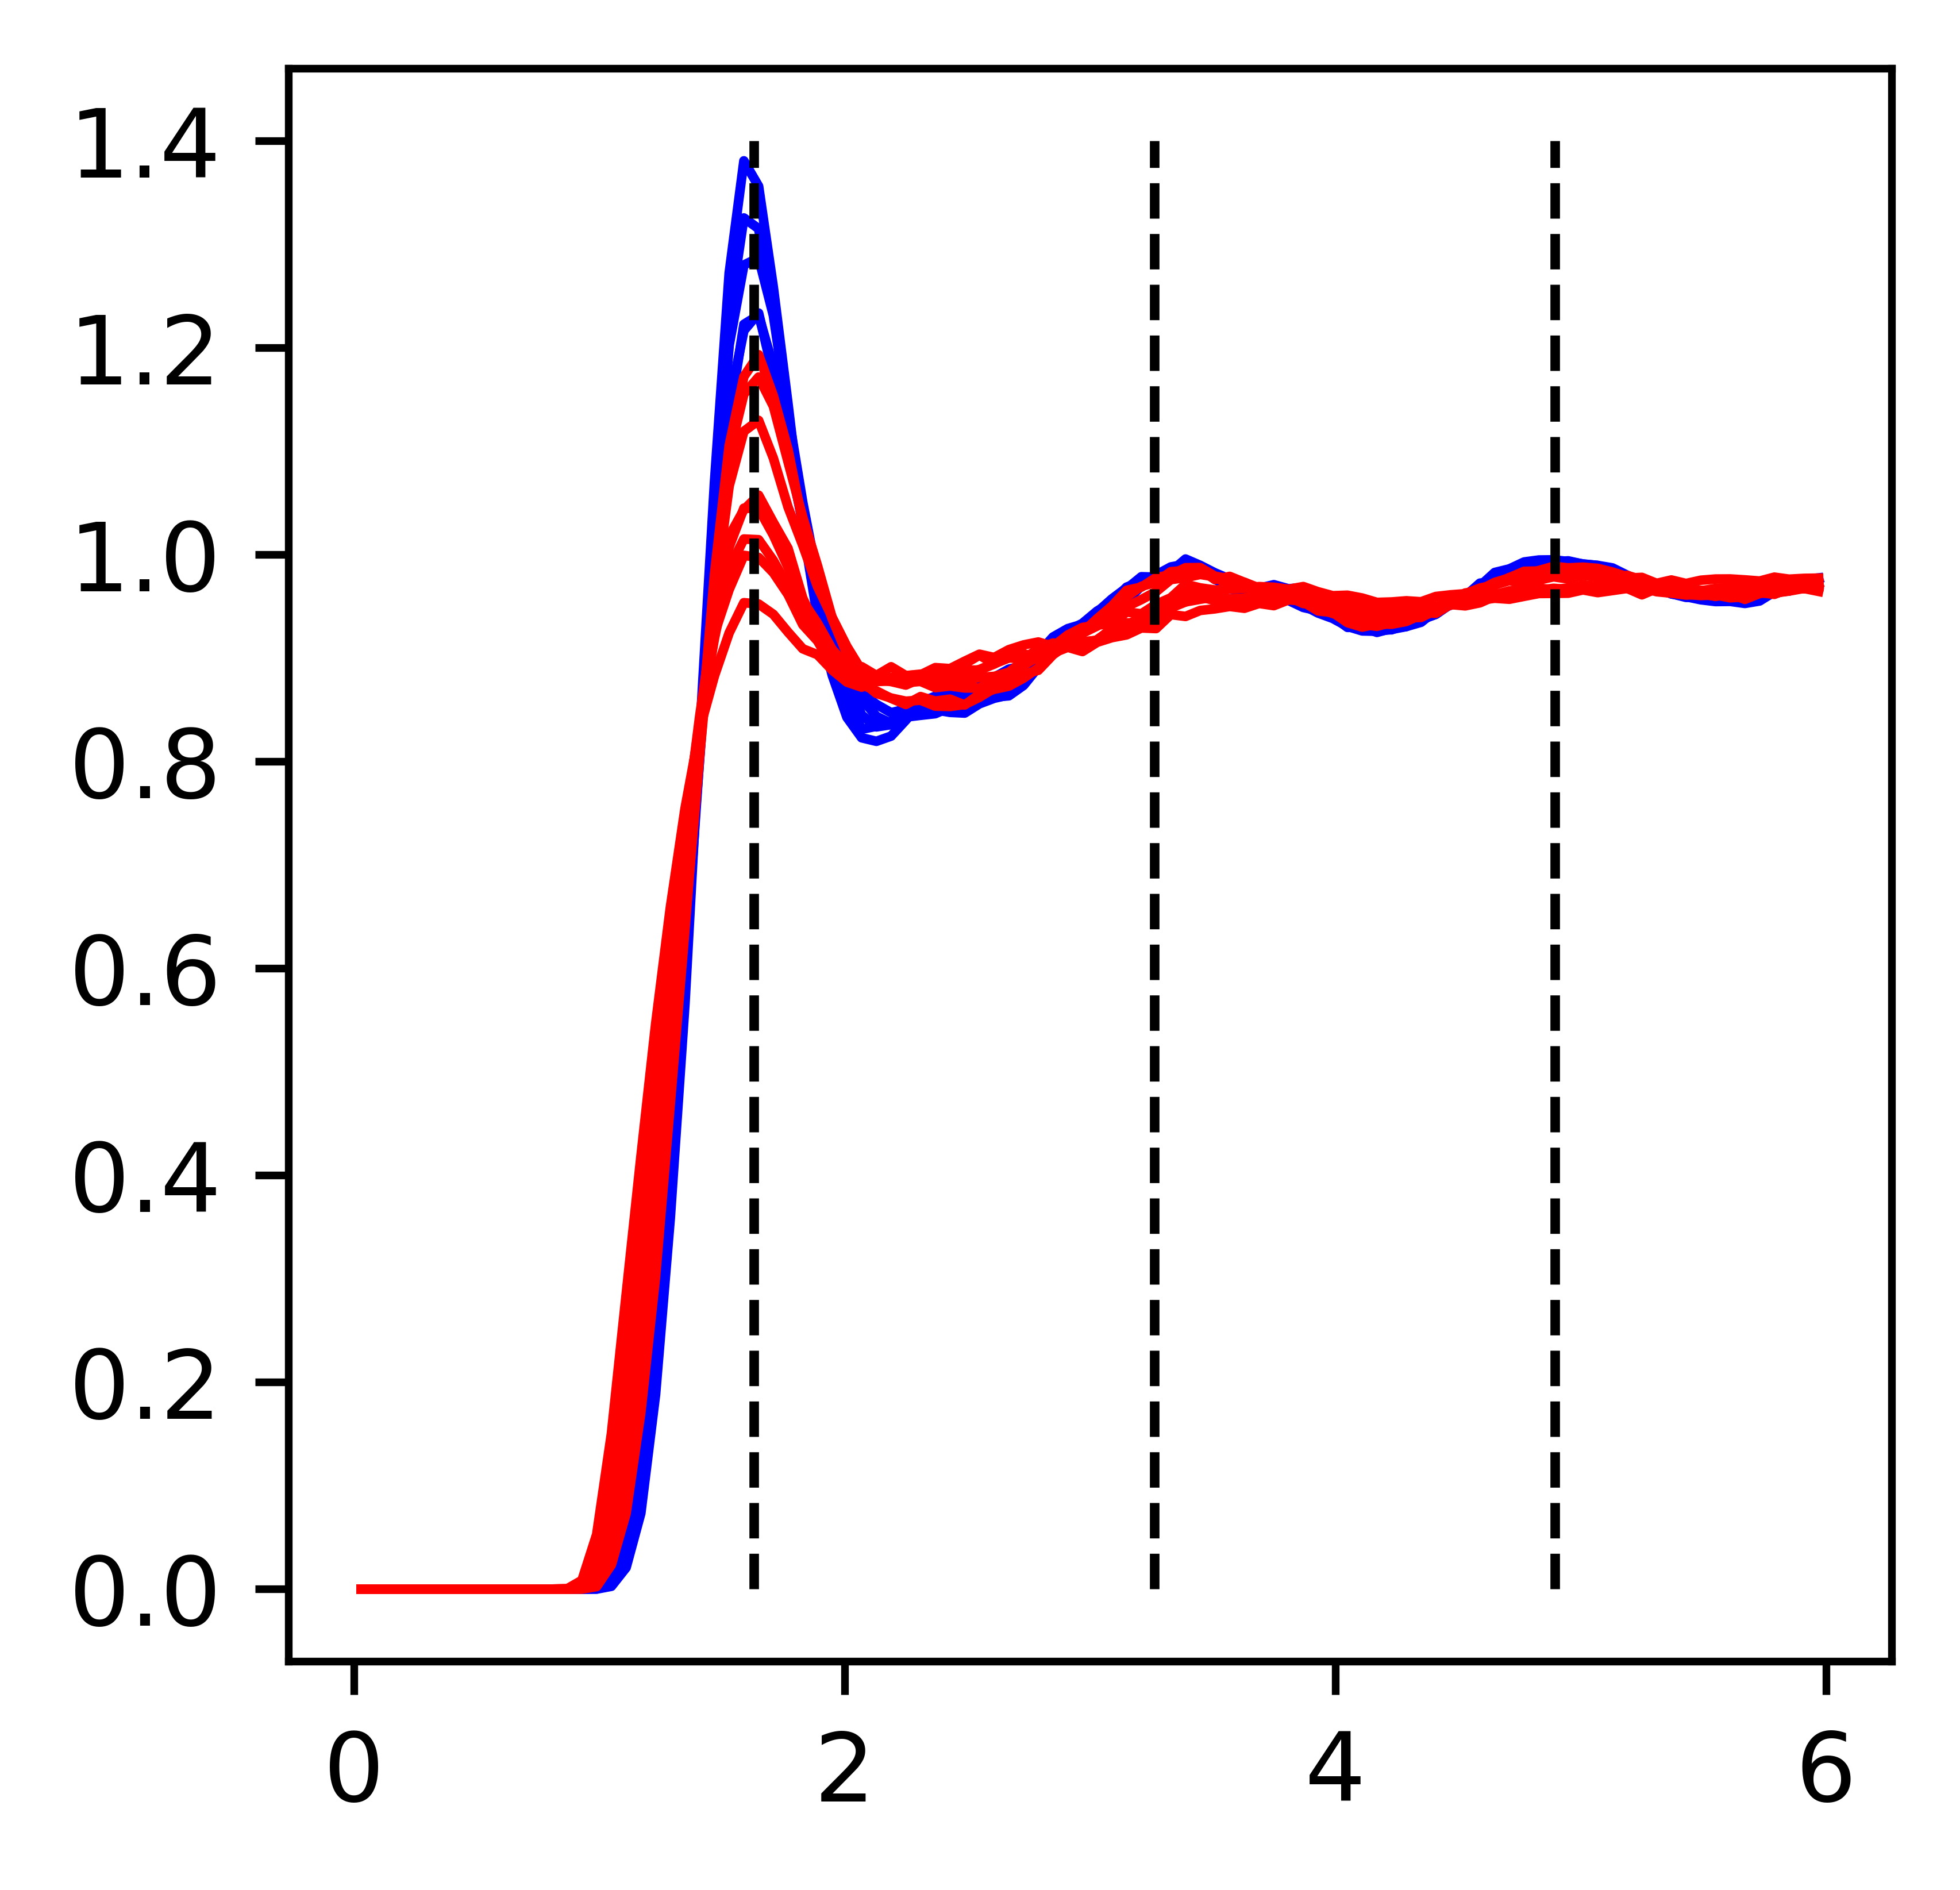

In [19]:
for kT, jobs in project.find_jobs({"pressure": 3.5, "lengths": 100}).groupby("kT"):
    if kT <= 1.8:
        c="blue"
    else:
        c="r"
    for job in jobs:
        try:
            rdf, N = gsd_rdf(
                gsdfile=job.fn(f"trajectory{int(job.doc.runs - 1)}.gsd"),
                A_name="A",
                B_name="A",
                exclude_bonded=True,
                start=-20,
                stop=-1,
                r_max=6
            )
            plt.plot(rdf.bin_centers, rdf.rdf, label=kT, c=c)
        except:
            print(job.id)
        
a = 0.561 / job.doc.ref_length
b = 0.867 / job.doc.ref_length

plt.vlines(x=a, ymin=0, ymax=1.4, linestyle="--", color="k")
#plt.vlines(x=b, ymin=0, ymax=1.4, linestyle="--", color="k")
plt.vlines(x=a * 2, ymin=0, ymax=1.4, linestyle="--", color="k")
plt.vlines(x=a * 3, ymin=0, ymax=1.4, linestyle="--", color="k")
#plt.vlines(x=b * 2, ymin=0, ymax=1.4, linestyle="--", color="k")
#plt.legend()